In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!pip install open3d 1>/dev/null
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import sys
import os
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

from tqdm import tqdm
import json

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud, visualize_pointcloud_patches
from models_adl4cv.patching import get_nearest_neighbors_batch_pytorch3d, generate_non_overlapping_patches, get_nearest_neighbors_batch_pytorch3d_indicies, non_overlapping_spectral_patches

In [3]:
import torch
import numpy as np
from pytorch3d.ops import knn_points
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import random
import logging

In [4]:
# !git pull

In [5]:
NPOINTS = 2048 * 3
CATEGORY = "chair"
BATCH_SIZE = 8 * 3 # 4
PATCH_SIZE = 512

In [6]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)


Total number of data:400
Min number of points: (train)2048 (test)2048


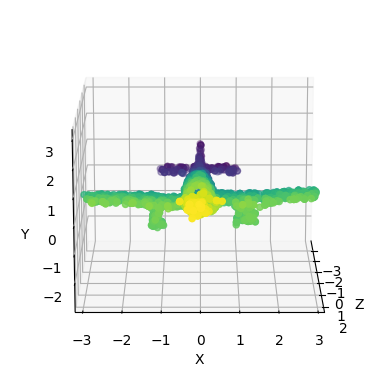

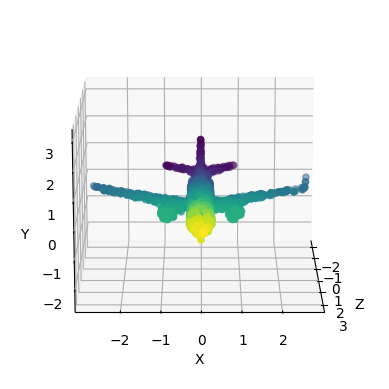

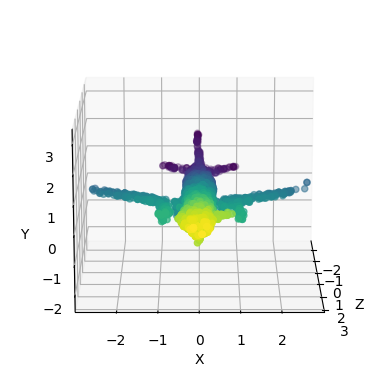

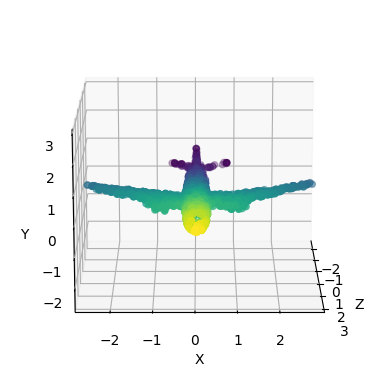

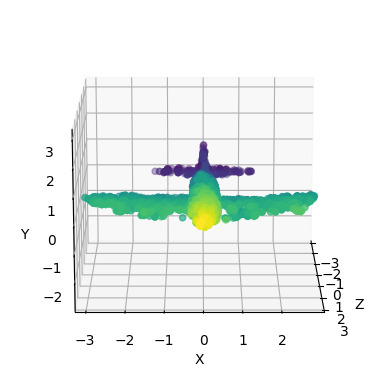

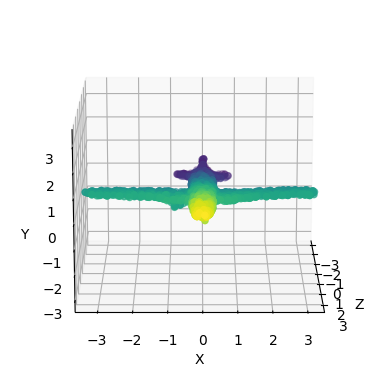

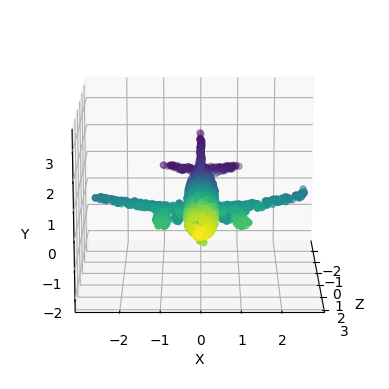

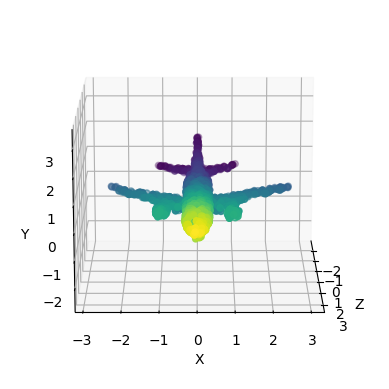

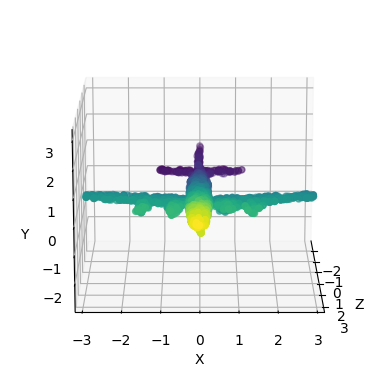

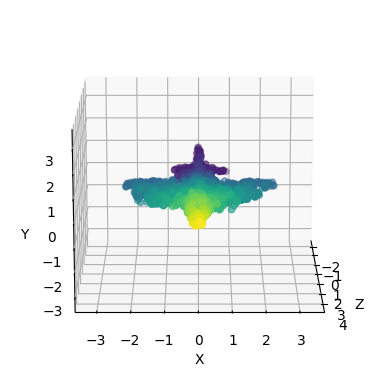

In [7]:
for i in range(10):
  pc = dataset_pvd[i]['train_points']
  visualize_pointcloud(pc)

In [8]:
INDEX = 6

In [9]:
point_cloud = dataset_pvd[INDEX]['train_points']

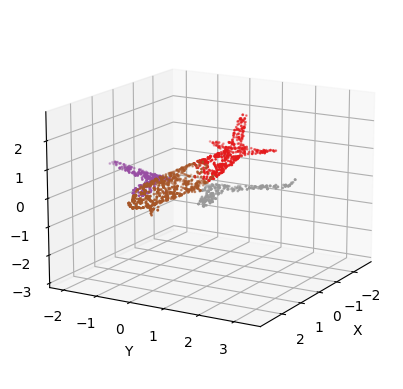

In [10]:
patches = non_overlapping_spectral_patches(point_cloud, patch_size=PATCH_SIZE, k=64)
_ = visualize_pointcloud_patches(patches)

## Mitsuba

In [ ]:
!pip install mitsuba
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt
from pathlib import Path, PosixPath

In [12]:
path = Path("visuals/poster/inference/")
path.mkdir(parents=True, exist_ok=True)

In [13]:
def beautiful(point_cloud, path: str):
  assert len(point_cloud.shape) == 2
  if type(point_cloud) is torch.Tensor:
    point_cloud = point_cloud.numpy()
  if type(path) is PosixPath:
    path = str(path)
  img = render_mitsuba(point_cloud, f"{path}.xml", fov=20, n_points=point_cloud.shape[0])
  plt.axis("off")
  plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
  plt.savefig(f"{path}.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
beautiful(point_cloud, path / "pvd")

In [ ]:
for index, patch in enumerate(patches):
  print(patch)
  beautiful(patch, path / f"{index}")

tensor([[ 0.8507,  0.6006,  2.7276],
        [-0.1781,  0.5775,  1.6859],
        [ 0.7469,  0.5949,  2.6857],
        ...,
        [-0.3347,  0.4078,  1.1021],
        [ 0.8286,  0.5891,  2.6638],
        [-0.7391,  0.5575,  2.6545]])
Center: [-0.01003391  0.84485567  1.6739788 ], Scale: 2.4103851318359375


## Util

In [ ]:
def load_pts_to_tensor(filename):
    with open(filename, 'r') as file:
        points = []
        for line in file:
            x, y, z = map(float, line.strip().split())
            points.append([x, y, z])
        return torch.tensor(points, dtype=torch.float32)

In [ ]:
point_cloud = torch.load("/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44/09-input.pth", map_location=torch.device('cpu'))

In [ ]:
img = render_mitsuba(point_cloud, "./test.xml", fov=20)

plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping~

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [ ]:
!pip install mitsuba
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44


In [ ]:
point_cloud = point_cloud.numpy().squeeze()

In [ ]:
point_cloud.shape

(2048, 3)

In [ ]:
base_dir = "/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44"

In [ ]:
data = {i: {typ: torch.load(f"{base_dir}/{i:02d}-{typ}.pth", map_location=torch.device('cpu')).numpy().squeeze() for typ in ("input", "refined_output")} for i in range(10)}

In [ ]:
print(data)

In [ ]:
for index, results in data.items():
  for typ, point_cloud in results.items():
    plot_name = f"./pt-{index}-{typ}"
    img = render_mitsuba(point_cloud, f"{plot_name}.xml", fov=20)
    plt.axis("off")
    plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
    plt.savefig(f"{plot_name}.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
for i in range(10):
  img = render_mitsuba(point_cloud, "./test.xml", fov=20)

In [ ]:
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("test.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
plt.savefig(f"test.png", dpi=400)